In [1]:
!pip install pafy youtube-dl moviepy

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
import cv2
import pafy
import math
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import load_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**Step0 : Download and Extract the Data**

The Dataset contains:

50 Action Categories<br>
25 Groups of Videos per Action Category<br>
133 Average Videos per Action Category<br>
199 Average Number of Frames per Video<br>
320 Average Frames Width per Video<br>
240 Average Frames Height per Video<br>
26 Average Frames Per Seconds per Video

In [ ]:
os.chdir('/content/drive/MyDrive/Human_activity_recognition')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Human_activity_recognition'

In [ ]:
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

**Step1 : Visualize the Data with its Labels**

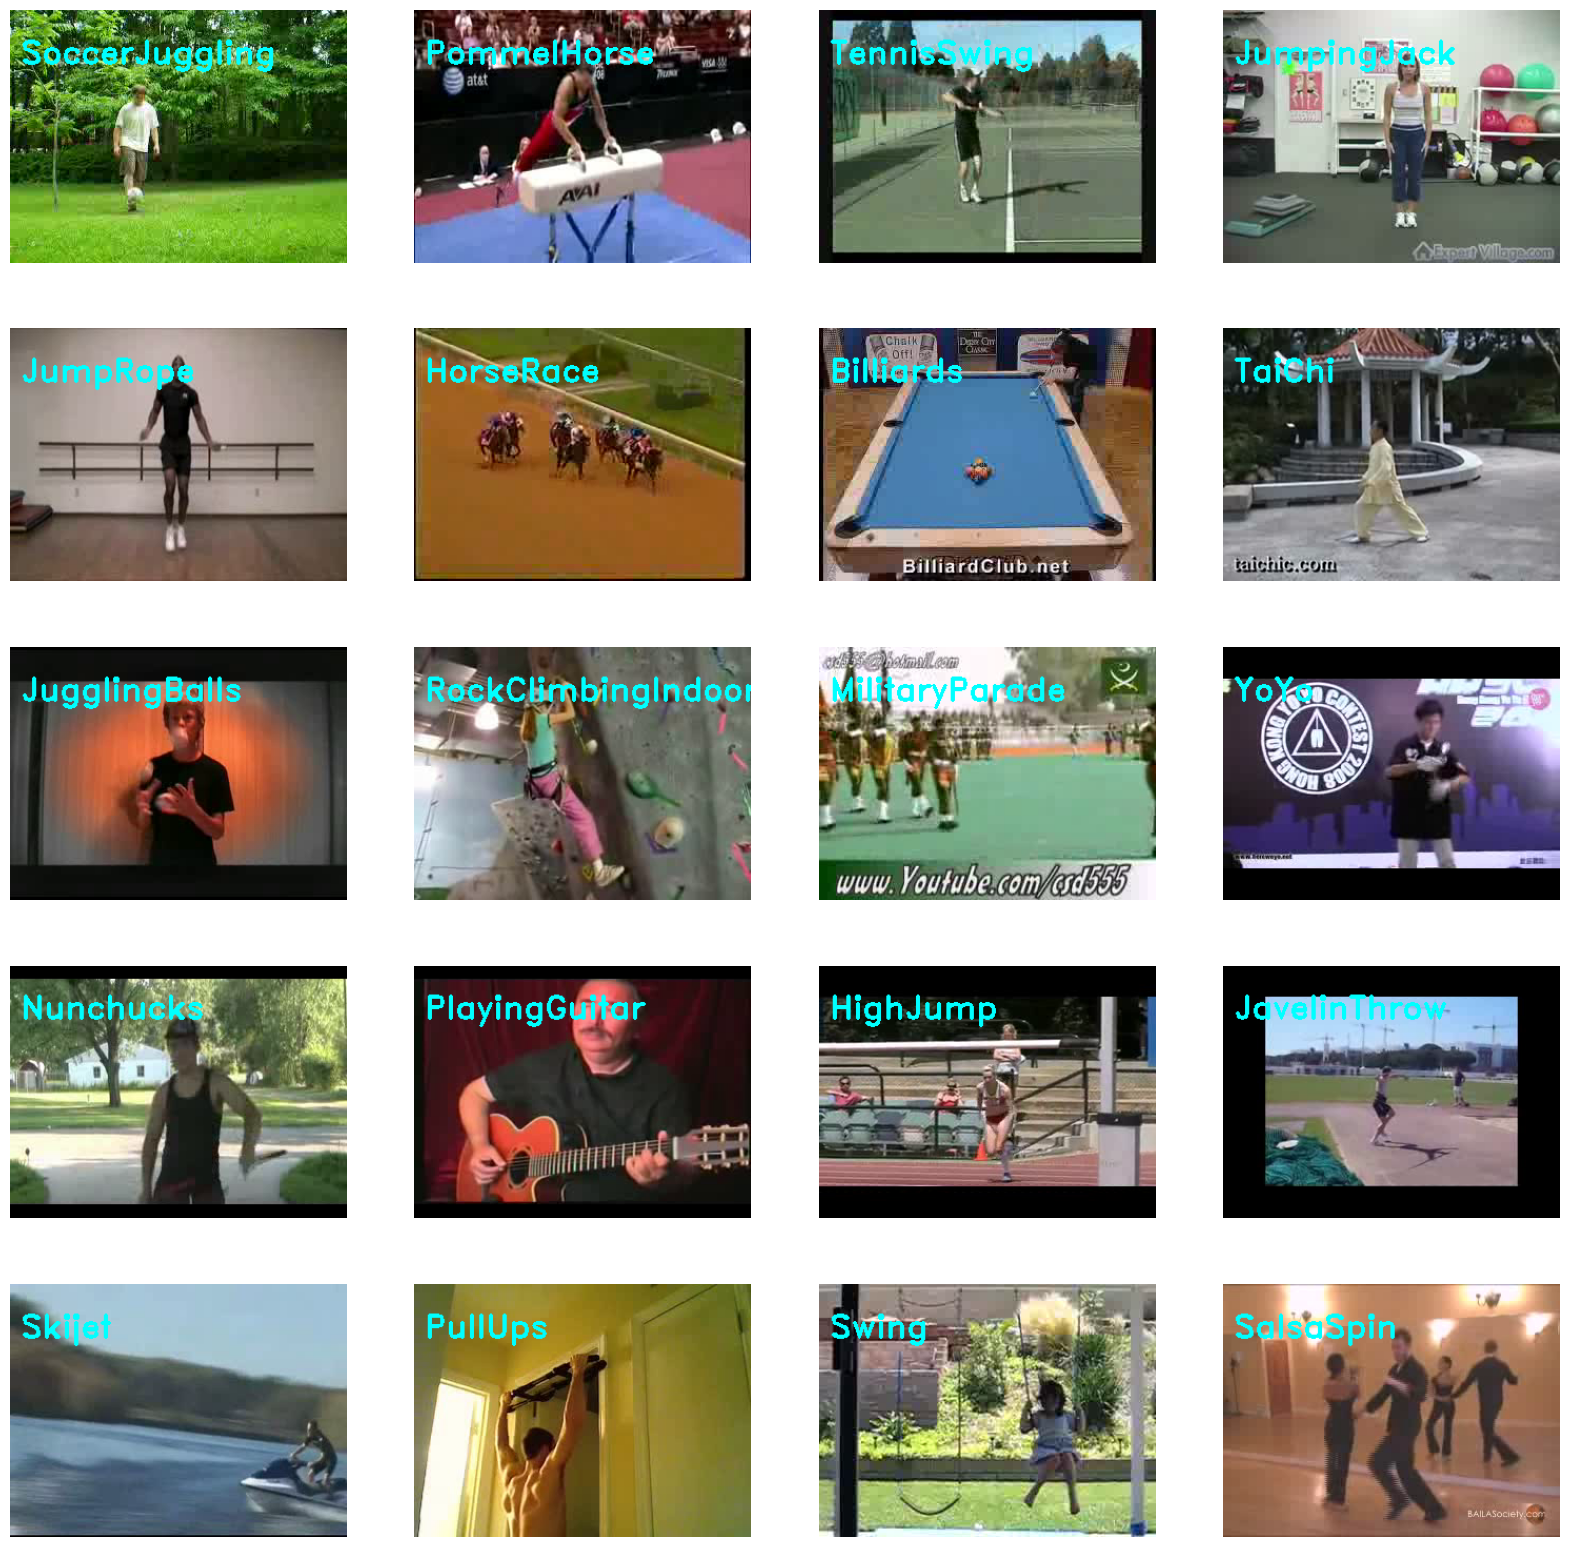

In [ ]:
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(f'/content/drive/MyDrive/Human_activity_recognition/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)


for counter, random_index in enumerate(random_range, 1):

  #Retrieve a class name using the Random Index.
  class_name = all_classes_names[random_index]

  #List of all Files inside the selected class directory
  video_files_name_list = os.listdir(f'/content/drive/MyDrive/Human_activity_recognition/UCF50/{class_name}')

  #Randomly select a video file from the selected class directory
  video_file_name = random.choice(video_files_name_list)

  # Initialize a VideoCapture object to read from the video File.
  video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Human_activity_recognition/UCF50/{class_name}/{video_file_name}')

  # Read the first frame of the video file.
  _, bgr_frame = video_reader.read()

  # Release the VideoCapture object.
  video_reader.release()

  # Convert the frame from BGR into RGB format.
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  #Write the class name on the video frame.
  cv2.putText(rgb_frame,
                class_name,
                (10, 50),
                cv2.FONT_HERSHEY_DUPLEX, 1,
                (0, 255, 255),
                2,
                cv2.LINE_4)

  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

**Step2 : Preprocess the Data**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range [0-1] by dividing the pixel values with 255, which makes convergence faster while training the network.

In [3]:
#Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

#Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

#Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/drive/MyDrive/Human_activity_recognition/UCF50"

#Specify the list containing the names of the classes used for training.
#Just to keep my training shorter, using only four classes
CLASSES_LIST = ["Basketball", "Billiards", "PushUps", "TennisSwing"]

In [ ]:
def frames_extraction(video_path):
  '''
  This function will extract the required frames from a video after resizing and normalizing them.
  Args:
    video_path: The path of the video in the disk, whose frames are to be extracted.
  Returns:
    frames_list: A list containing the resized and normalized frames of the video.
  '''
  frames_list = []

  # Read the Video File using the VideoCapture object.
  video = cv2.VideoCapture(video_path)

  # Get the total number of frames in the video.
  video_frames_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the the interval after which frames will be added to the list.
  skip_frames_window = max(video_frames_count//SEQUENCE_LENGTH, 1)

  for i in range(0,SEQUENCE_LENGTH):
    # Set the current frame position of the video.
    video.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames_window)

    # Reading the frame from the video.
    success,frame = video.read()

    #Video frame not successfully Read break the Loop
    if not success:
      break

    # Resize the Frame to fixed height and width.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    normalized_frame = resized_frame / 255

    frames_list.append(normalized_frame)

  video.release()
  return frames_list


In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features,labels,video_files_path = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: Billiards
Extracting Data of Class: PushUps
Extracting Data of Class: TennisSwing


In [ ]:
from collections import Counter
Counter(labels)

Counter({0: 137, 1: 150, 2: 106, 3: 167})

In [ ]:
features.shape

(560, 20, 64, 64, 3)

In [ ]:
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

Step3 : Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state= seed_constant)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
convlstm = create_convlstm_model()
print("Model Created Successfully")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 20, 31, 31, 4)     0         
 g3D)                                                            
                                                                 
 time_distributed_15 (TimeD  (None, 20, 31, 31, 4)     0         
 istributed)                                                     
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                      

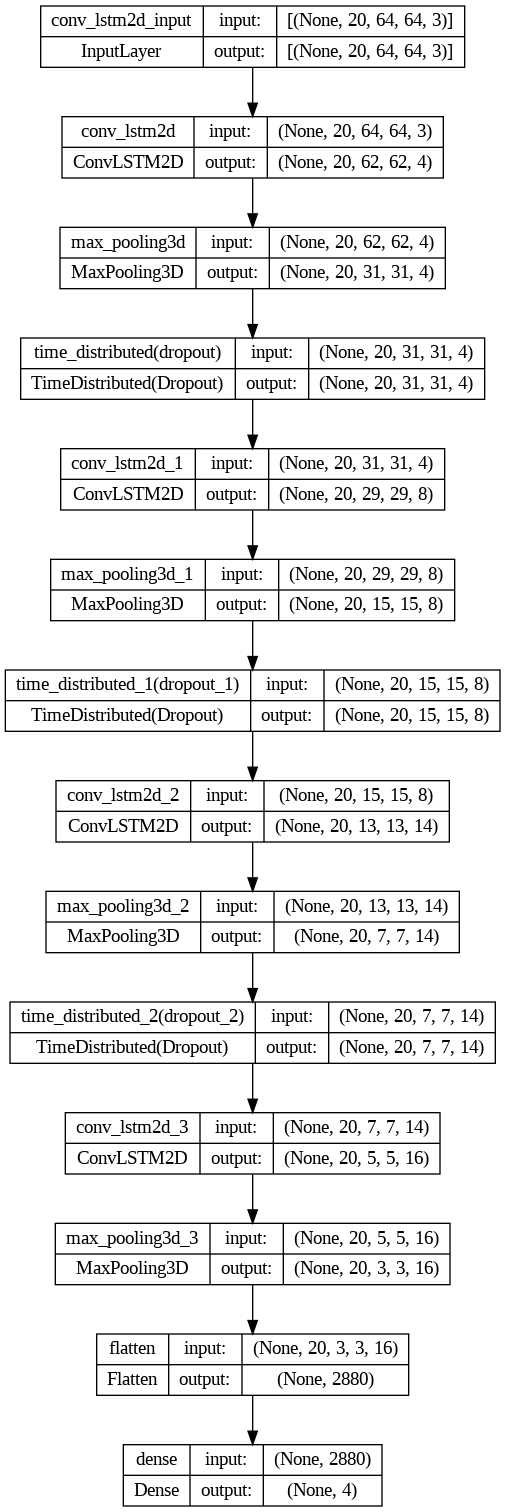

In [ ]:
plot_model(convlstm,to_file = '/content/drive/MyDrive/Human_activity_recognition/convlstm_model_structure_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience=10,mode='min',restore_best_weights=True)

convlstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])

convlstm_model_training_history = convlstm.fit(X_train,y_train,
                                  epochs = 50,
                                  batch_size = 4,
                                  shuffle=True,
                                  validation_split = 0.2 ,
                                  callbacks = [early_stopping_callback])

Epoch 1/50
84/84 [==============================] - 161s 2s/step - loss: 1.2709 - accuracy: 0.4018 - val_loss: 0.7257 - val_accuracy: 0.6786
Epoch 2/50
84/84 [==============================] - 139s 2s/step - loss: 0.7049 - accuracy: 0.6875 - val_loss: 0.6543 - val_accuracy: 0.7500
Epoch 3/50
84/84 [==============================] - 142s 2s/step - loss: 0.5955 - accuracy: 0.7679 - val_loss: 0.5353 - val_accuracy: 0.7500
Epoch 4/50
84/84 [==============================] - 153s 2s/step - loss: 0.4269 - accuracy: 0.8304 - val_loss: 0.4026 - val_accuracy: 0.8690
Epoch 5/50
84/84 [==============================] - 140s 2s/step - loss: 0.2842 - accuracy: 0.9077 - val_loss: 0.4114 - val_accuracy: 0.8571
Epoch 6/50
84/84 [==============================] - 148s 2s/step - loss: 0.2062 - accuracy: 0.9256 - val_loss: 0.3352 - val_accuracy: 0.8690
Epoch 7/50
84/84 [==============================] - 141s 2s/step - loss: 0.1339 - accuracy: 0.9435 - val_loss: 0.3020 - val_accuracy: 0.9167
Epoch 8/50
84

Model Evaluation

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm.evaluate(X_test, y_test)

5/5 [==============================] - 18s 3s/step - loss: 0.1763 - accuracy: 0.9429


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model2___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm.save(f'/content/drive/MyDrive/Human_activity_recognition/{model_file_name}')

  saving_api.save_model(



In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

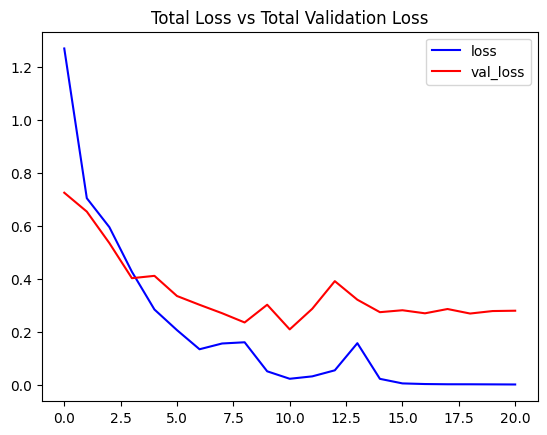

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

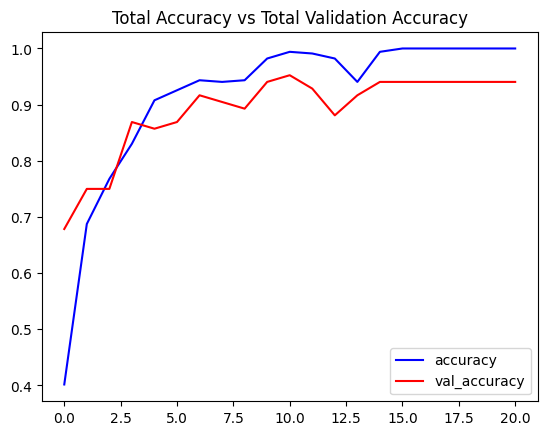

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**Step 5: Implement the LRCN Approach**

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, 20, 4, 4, 32)     

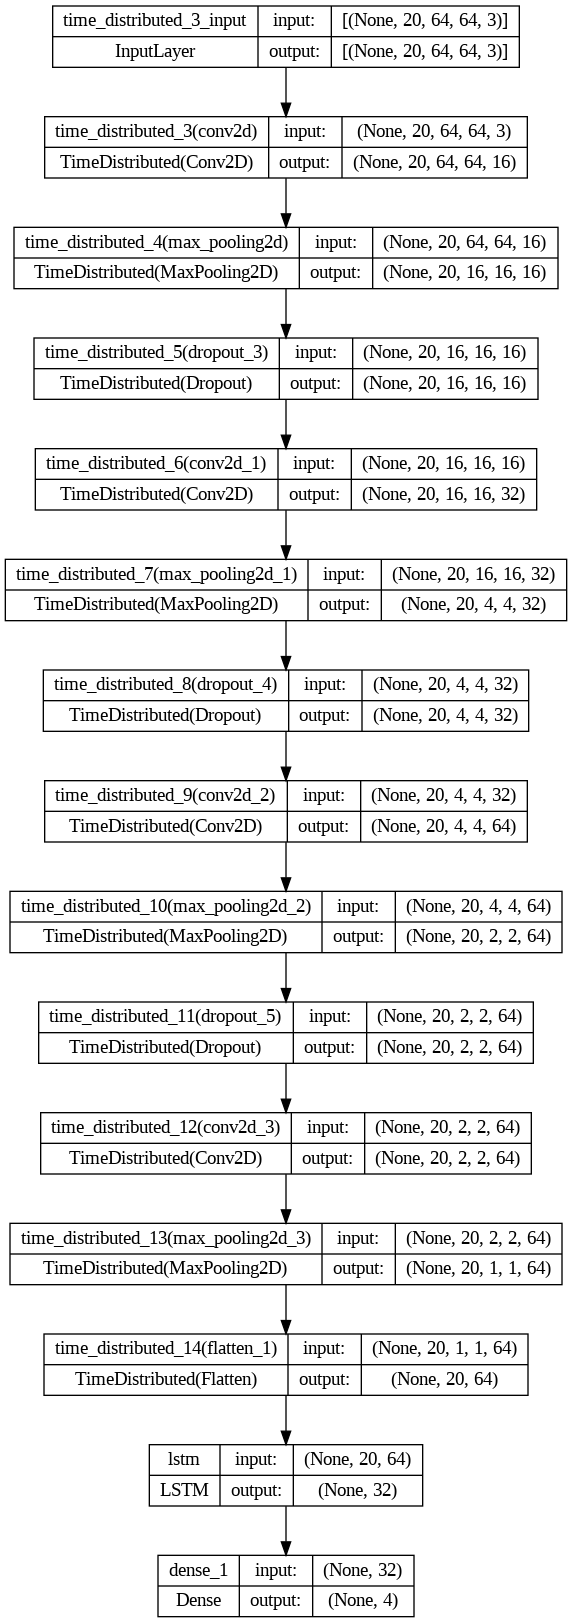

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = '/content/drive/MyDrive/Human_activity_recognition/LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = X_train, y = y_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
84/84 [==============================] - 20s 184ms/step - loss: 1.3175 - accuracy: 0.3750 - val_loss: 0.8869 - val_accuracy: 0.5238
Epoch 2/70
84/84 [==============================] - 15s 179ms/step - loss: 0.9817 - accuracy: 0.5179 - val_loss: 0.8534 - val_accuracy: 0.5357
Epoch 3/70
84/84 [==============================] - 18s 213ms/step - loss: 0.9024 - accuracy: 0.5268 - val_loss: 0.9177 - val_accuracy: 0.5238
Epoch 4/70
84/84 [==============================] - 16s 189ms/step - loss: 0.8791 - accuracy: 0.5536 - val_loss: 0.7648 - val_accuracy: 0.6429
Epoch 5/70
84/84 [==============================] - 15s 179ms/step - loss: 0.7562 - accuracy: 0.6756 - val_loss: 0.6844 - val_accuracy: 0.7262
Epoch 6/70
84/84 [==============================] - 15s 178ms/step - loss: 0.7410 - accuracy: 0.6875 - val_loss: 0.5967 - val_accuracy: 0.7381
Epoch 7/70
84/84 [==============================] - 15s 179ms/step - loss: 0.5601 - accuracy: 0.7470 - val_loss: 0.4211 - val_accuracy: 0.8452

In [ ]:
model_evaluation_history = LRCN_model.evaluate(X_test,y_test)

5/5 [==============================] - 3s 377ms/step - loss: 0.1155 - accuracy: 0.9786


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model2___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(f'/content/drive/MyDrive/Human_activity_recognition/{model_file_name}')

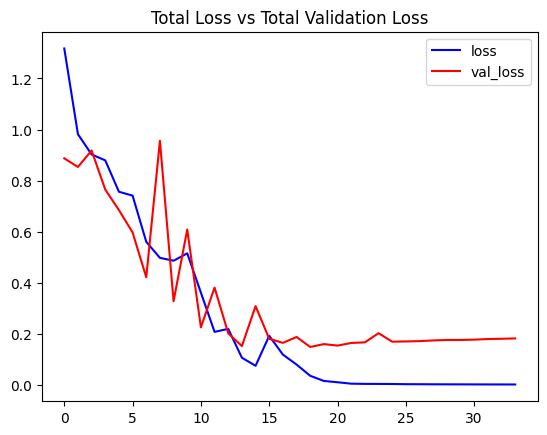

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

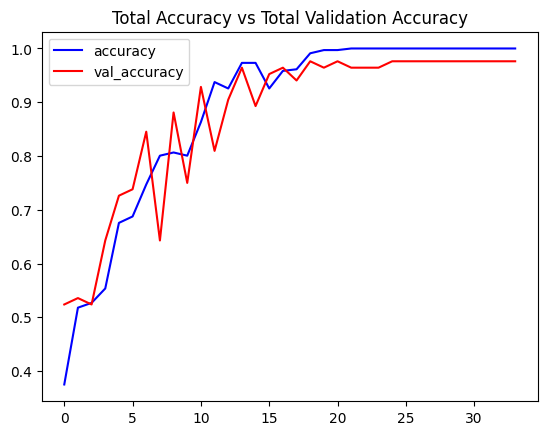

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**Step 6: Test the Best Performing Model on YouTube videos**


In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'/content/drive/MyDrive/Human_activity_recognition/{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

In [ ]:
url = "https://www.youtube.com/watch?v=8u0qjmHIOcE"

# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(f'/content/drive/MyDrive/Human_activity_recognition/{test_videos_directory}', exist_ok = True)

# Download a YouTube Video.
#video_title = download_youtube_videos(url, test_videos_directory)
video_title = r'test_video.mp4'

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'/content/drive/MyDrive/Human_activity_recognition/{test_videos_directory}/{video_title}'

In [6]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH,model):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    Model: The Model on which the prediction has to made
    '''

    os.makedirs(os.path.dirname(output_video_file_path), exist_ok = True)

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
output_videos_directory = 'output_videos'

# Construct the output video path.
output_video_file_path = f'/content/drive/MyDrive/Human_activity_recognition/{output_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 32ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  99%|█████████▉| 474/480 [00:02<00:00, 123.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Human_activity_recognition/output_videos/test_video.mp4-Output-SeqLen20.mp4, 151200 bytes wanted but 0 bytes read,at frame 479/480, at time 15.97/15.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**Load the Trained Model and Predict**

In [7]:
lrcn2_savedModel=load_model('/content/drive/MyDrive/Human_activity_recognition/LRCN_model2___Date_Time_2024_01_13__13_22_25___Loss_0.1154843345284462___Accuracy_0.9785714149475098.h5')
lrcn2_savedModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, 20, 4, 4, 32)     

In [8]:
test_videos_directory = 'test_videos'
output_videos_directory = 'output_videos'

video_title = r'test_video.avi'

input_video_file_path = f'/content/drive/MyDrive/Human_activity_recognition/{test_videos_directory}/{video_title}'
output_video_file_path = f'/content/drive/MyDrive/Human_activity_recognition/{output_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.avi'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH,lrcn2_savedModel)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 133ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
